In [1]:
from dataset import *
from model import *
from tqdm import tqdm
import os
import matplotlib.pyplot as plt

In [2]:
class trainfc():
    def __init__(self, in_num, out_num, layers, node_num, csv_path, batchsize, epochs):
        self.fcmodel = fcnet(in_num, out_num, layers, node_num)
        self.in_num = in_num
        self.fcmodel.train()
        self.dataset = Dataset(csv_path, 'train', False)
        self.batchsize = batchsize
        self.train_loader = paddle.io.DataLoader(self.dataset, batch_size=batchsize, shuffle=True)
        self.epochs = epochs
        self.losslist = []
        self.acclist = []
        model_info = paddle.summary(self.fcmodel, (1, in_num))
        print(model_info)
        self.dataset.showlabel()
        
    def train(self):
        optim = paddle.optimizer.Adam(parameters=self.fcmodel.parameters())
        loss_fn = paddle.nn.MSELoss()
        acc_fn = Precision()
        with tqdm(total=self.epochs*len(self.dataset)/self.batchsize) as pbar:
            pbar.set_description('[Training] loss: nan, acc: 0.00%')
            for epoch in range(self.epochs):
                for batch_id, data in enumerate(self.train_loader()):
                    inp = data[0]
                    label = data[1]
                    predicts = self.fcmodel(inp)
                    acc_fn.update(predicts, label)
                    acc = acc_fn.accumulate()
                    acc_fn.reset()
                    loss = loss_fn(predicts, label)
                    loss.backward()
                    optim.step()
                    optim.clear_grad()
                    pbar.set_description('[Training] loss: %.2f, acc: %.2f%%' % (loss.numpy(), 100*acc))
                    pbar.update(1)
                    self.losslist.append(loss.numpy())
                    self.acclist.append(100*acc)
    
    def visualize(self, path2save, name = "fcmodel"):
        l = np.array(self.losslist)
        x_axis = len(l)
        step = np.linspace(1,x_axis,x_axis)
        plt.plot(step,l,label="Train Loss")
        plt.legend(loc='upper right')
        plt.title('step-loss')
        plt.xlim((0, x_axis))
        plt.ylim((0, 1))
        plt.gca().set_ylim(bottom=0)
        plt.xlabel('step')
        plt.ylabel('loss')
        plt.savefig(os.path.join(path2save, 'loss_%s.png' % name), bbox_inches='tight')
        plt.show()

        a = np.array(self.acclist)
        plt.plot(step,a,label="Train Acc")
        plt.legend(loc='upper right')
        plt.title('step-acc')
        plt.xlim((0, x_axis))
        plt.ylim((0, 100))
        plt.gca().set_ylim(bottom=0)
        plt.xlabel('step')
        plt.ylabel('acc')
        plt.savefig(os.path.join(path2save,'acc_%s.png' % name), bbox_inches='tight')
        plt.show()
        print("[Visualization] Done!")
    
    def save(self, path2save, name = "fcmodel"):
        paddle.jit.save(
            layer=self.fcmodel,
            path=os.path.join(path2save, name),
            input_spec=[
                paddle.static.InputSpec(shape=[1, self.in_num], dtype='float32')
                ])

        paddle.onnx.export(
            self.fcmodel, 
            os.path.join(path2save, name), 
            input_spec = [
                paddle.static.InputSpec(shape=[1, self.in_num], dtype='float32')
                ], opset_version=12)
        print("[Model Save] Done!")

[Dataset::labelencoder] Max of [id] is: 22500.00
[Dataset::labelencoder] Max of [age] is: 101.00
[Dataset::labelencoder] Max of [duration] is: 5149.00
[Dataset::labelencoder] Max of [campaign] is: 57.00
[Dataset::labelencoder] Max of [pdays] is: 1048.00
[Dataset::labelencoder] Max of [previous] is: 6.00
[Dataset::labelencoder] Max of [emp_var_rate] is: 3.40
[Dataset::labelencoder] Max of [cons_price_index] is: 99.46
[Dataset::labelencoder] Max of [cons_conf_index] is: 53.28
[Dataset::labelencoder] Max of [lending_rate3m] is: 5.27
[Dataset::labelencoder] Max of [nr_employed] is: 5489.50
---------------------------------------------------------------------------
 Layer (type)       Input Shape          Output Shape         Param #    
   Linear-1          [[1, 20]]            [1, 2048]           43,008     
   Sigmoid-1          [[1, 1]]              [1, 1]               0       
 BatchNorm1D-1      [[1, 2048]]           [1, 2048]            8,192     
   Linear-2         [[1, 2048]]    

[Training] loss: nan, acc: 0.00%:   0%|                                                     | 0/1800.0 [00:00<?, ?it/s]D:\Minicoda3\envs\paddle\lib\site-packages\paddle\nn\layer\norm.py:653: UserWarning: When training, we now always track global mean and variance.
  warnings.warn(
[Training] loss: 0.01, acc: 98.72%: 100%|████████████████████████████████████████| 1800/1800.0 [03:42<00:00,  8.07it/s]


2022-12-31 16:14:00 [INFO]	Static PaddlePaddle model saved in model.save\paddle_model_static_onnx_temp_dir.
2022-12-31 16:14:01 [INFO]	ONNX model saved in model.save\fcmodel_norm_sigmoid.onnx.
[Model Save] Done!


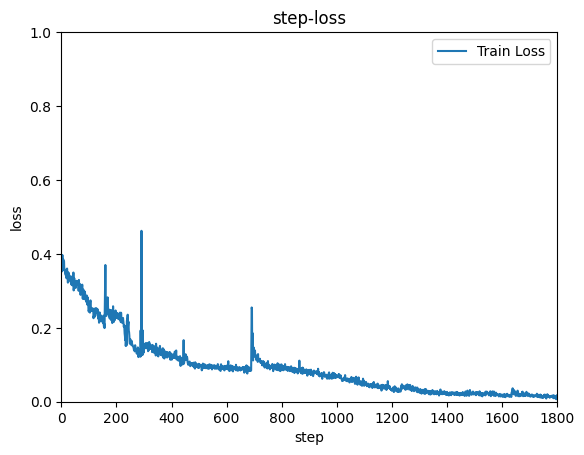

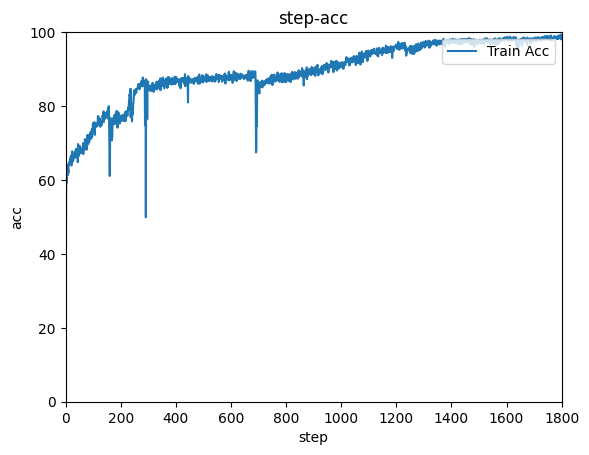

[Visualization] Done!
Tensor(shape=[10, 1], dtype=float32, place=Place(gpu:0), stop_gradient=False,
       [[0.00028062],
        [0.99962640],
        [0.00038241],
        [0.99984419],
        [0.02673158],
        [0.00817367],
        [0.00048007],
        [0.03253078],
        [0.00552740],
        [0.99989223]])


In [3]:
if __name__=="__main__":
    fcmodel = trainfc(20, 1, 5, 2048, "data/train.csv", 2500, 200)
    fcmodel.train()
    fcmodel.save('model.save', "fcmodel_norm_sigmoid")
    fcmodel.visualize('statics', "fcmodel_norm_sigmoid")
    
    fcmodel.fcmodel.eval()
    inp = []
    for j in range(0, 10):
        inp_j, _ = fcmodel.dataset.__getitem__(j)
        inp.append(inp_j)
    inp = paddle.Tensor(np.float32(np.array(inp)))
    pred = fcmodel.fcmodel(inp)
    print(pred)